## Snow and ice classification

### Objective

Apply a simple snow and ice classification derived from a knowledge-based approach.

Note: the knowledge-based is not part of this notebook. Results are a simple example of how to apply such a method

### The Python modules required

In [1]:
from string import Template
from shapely.geometry import box
from shapely.wkt import loads

import os
import gdal, osr
import dateutil.parser as parser

from timeit import default_timer as timer


import sys 

from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### Read the sigma0 data produced in the SNAP introduction notebook

In [2]:
sigma0_tif = 'sigma0.tif'

In [3]:
reader = ProductIO.getProductReader('GeoTIFF')
product = reader.readProductNodes(sigma0_tif, None)

In [4]:
band_names = list(product.getBandNames())

In [5]:
band_names

['Sigma0_HH_db', 'Sigma0_HV_db', 'elevation']

### Create the band expression to classify the snow and ice

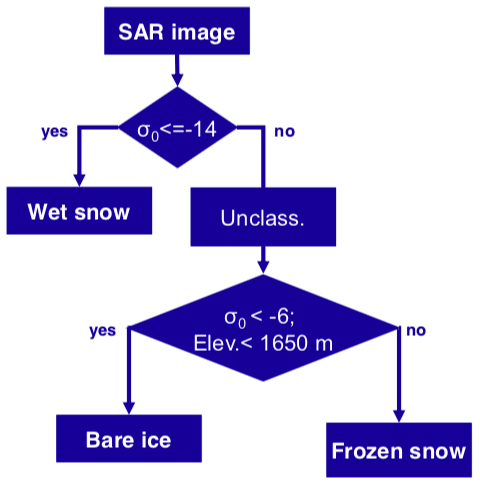

In [6]:
from IPython.display import Image
Image(filename='resources/sar_kb.png') 

In [7]:
band_expression = Template('if $dem == -500 then 0 else if $sigma0 < -14 then 10 else if $sigma0 < -6 and $dem < 1650 then 20 else 30')

Use the SNAP BandMaths Operator to apply the expression for HH and HV sigma0 derived data:

In [8]:
BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 2)     

targetBand_HH = BandDescriptor()
    
targetBand_HH.expression = band_expression.substitute(sigma0=list(band_names)[0], dem=list(band_names)[2])
        
targetBand_HH.name = 'snow_ice_classification_HH'
targetBand_HH.type = 'int8'
    
targetBands[0]= targetBand_HH


targetBand_HV = BandDescriptor()
    
targetBand_HV.expression = band_expression.substitute(sigma0=list(band_names)[1], dem=list(band_names)[2])
        
targetBand_HV.name = 'snow_ice_classification_HV'
targetBand_HV.type = 'int8'
    
targetBands[1]= targetBand_HV

        
parameters = HashMap()
parameters.put('targetBands', targetBands)

snow_and_ice_product = GPF.createProduct('BandMaths', parameters, product)

ProductIO.writeProduct(snow_and_ice_product, 'snow_and_ice.tif' , 'GeoTIFF-BigTiff')

### Plot the results

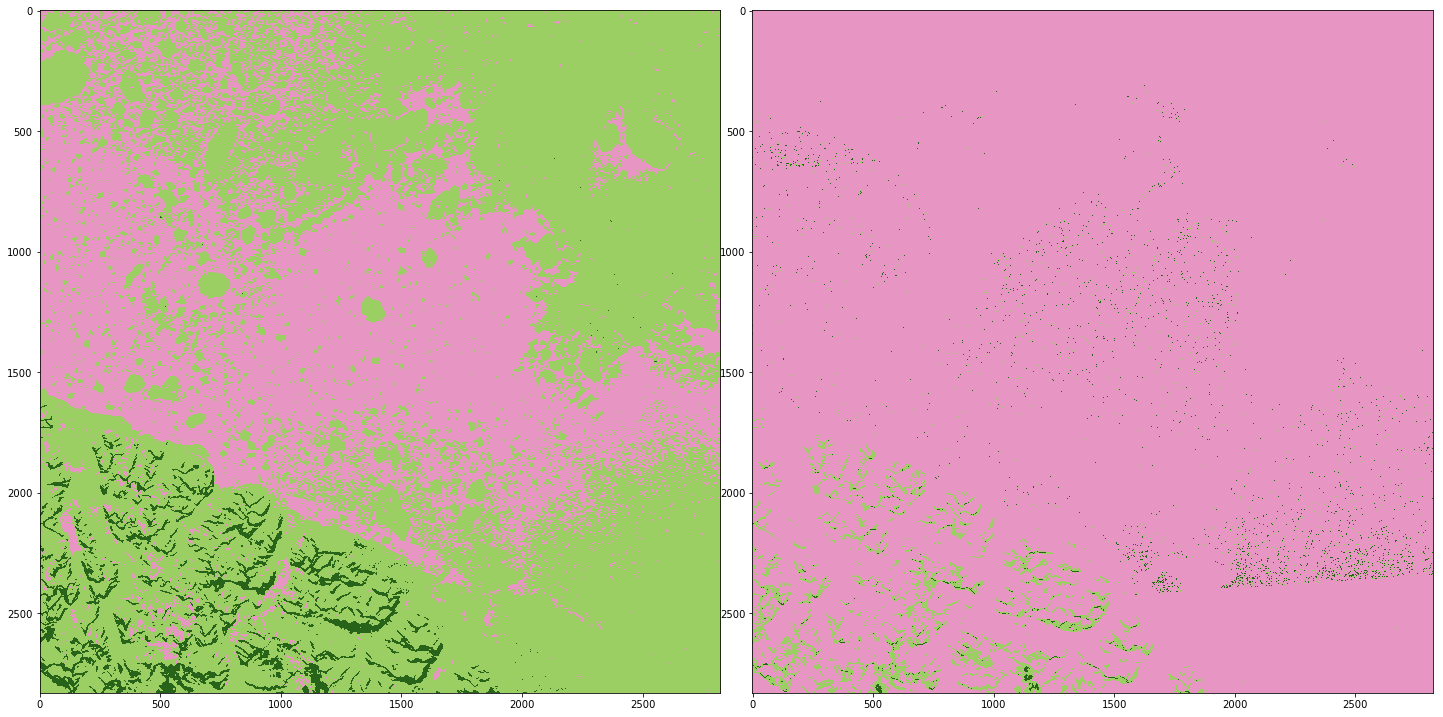

In [9]:
fig = plt.figure(figsize=(20,20))
 
for i in [0,1]:

    a=fig.add_subplot(2, 2, 0+i+1)
    
    data = snow_and_ice_product.getBand(snow_and_ice_product.getBandNames()[i])

    w = data.getRasterWidth()  
    h = data.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    data.readPixels(0, 0, w, h, band_data)
    band_data.shape = h, w

    cmap = plt.cm.get_cmap('PiYG', 5)

    imgplot = plt.imshow(band_data,
                             cmap=cmap,
                             vmin=0, 
                             vmax=30)
    
    
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()

### License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.